In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [16]:
#Loading the data
data = pd.read_csv('C:/Users/Mrinal Kalita/Python Projects/Text Generation/medium_data.csv')

In [17]:
#checking the first 5 rows
data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [18]:
#Checking the shape
data.shape

(6508, 10)

In [19]:
#checking some of the titles
data['title'][1]

'Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric'

In [20]:
data['title'][11]

'Making a DotA2 Bot Using\xa0ML'

In [21]:
#Removing unwanted characters from title
data['title'] = data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
data['title'] = data['title'].apply(lambda x: x.replace(u'\u200a',' '))

## Tokenization

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(data['title'])
total_words = len(tokenizer.word_index) + 1

In [24]:
print('total number of words:', total_words)
print('oov word index:', tokenizer.word_index['<oov>'])

total number of words: 8238
oov word index: 1


In [25]:
tokenizer.texts_to_sequences([data['title'][0]])[0]

[5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99]

In [26]:
input_sequence = []

for line in data['title']:
    input_token = tokenizer.texts_to_sequences([line])[0]

    for i in range(1,len(input_token)):
        n_gram = input_token[:i+1]
        input_sequence.append(n_gram)

## Making same length through padding

In [27]:
#Finding the maximum length
max_len = max([len(i) for i in input_sequence])

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
input_sequence = pad_sequences(input_sequence,maxlen=max_len,padding='pre')

In [29]:
input_sequence[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,
       676])

## Creatig Feature and Labels

In [30]:
#Creating feature and labels
predictors, target = input_sequence[:,:-1], input_sequence[:,-1]

In [31]:
target

array([676,  68,   2, ...,  56, 730, 550])

In [32]:
labels = tf.keras.utils.to_categorical(target,num_classes= total_words)

## LSTM model building

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(total_words,100,input_length = max_len-1))
model.add(tf.keras.layers.LSTM(256,return_sequences = True))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(total_words, activation = 'softmax'))

In [21]:
#Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(decay=1e-6),loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 100)           823800    
_________________________________________________________________
lstm (LSTM)                  (None, 39, 256)           365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 8238)              1062702   
Total params: 2,449,190
Trainable params: 2,449,190
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Defining the callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
stop = EarlyStopping(patience=15,monitor='loss')
reduce_lr = ReduceLROnPlateau(factor=0.125,patience=6,monitor = 'loss')

In [25]:
#Training the model
history = model.fit(predictors,labels,epochs=100,callbacks=[stop,reduce_lr],verbose=1)

Epoch 1/100
1515/1515 [==============================] - 100s 66ms/step - loss: 7.1300 - accuracy: 0.0567
Epoch 2/100
1515/1515 [==============================] - 62s 41ms/step - loss: 6.5585 - accuracy: 0.1091
Epoch 3/100
1515/1515 [==============================] - 65s 43ms/step - loss: 6.2632 - accuracy: 0.1288
Epoch 4/100
1515/1515 [==============================] - 73s 48ms/step - loss: 5.9702 - accuracy: 0.1436
Epoch 5/100
1515/1515 [==============================] - 106s 70ms/step - loss: 5.6958 - accuracy: 0.1569
Epoch 6/100
1515/1515 [==============================] - 161s 106ms/step - loss: 5.4483 - accuracy: 0.1685
Epoch 7/100
1515/1515 [==============================] - 79s 52ms/step - loss: 5.2217 - accuracy: 0.1774
Epoch 8/100
1515/1515 [==============================] - 140s 93ms/step - loss: 5.0064 - accuracy: 0.1872
Epoch 9/100
1515/1515 [==============================] - 189s 125ms/step - loss: 4.7886 - accuracy: 0.1977
Epoch 10/100
1515/1515 [========================

In [26]:
model.save('model.h5')

In [27]:
#Saving the history in csv file
hist = pd.DataFrame({'epochs':history.epoch,'loss':history.history['loss'],'accuracy':history.history['accuracy']})
hist.to_csv('model_history.csv')

In [3]:
history = pd.read_csv('C:/Users/Mrinal Kalita/Python Projects/Text Generation/model_history.csv')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Accuracy')

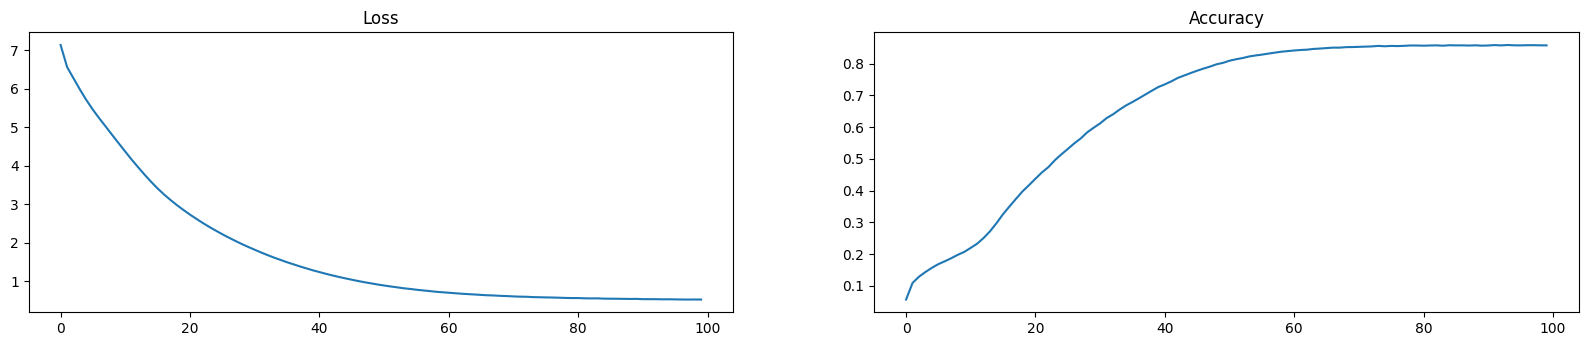

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history['epochs'],history['loss'])
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(history['epochs'],history['accuracy'])
plt.title('Accuracy')

## Text Generation Prediction

In [11]:
model = tf.keras.models.load_model('C:/Users/Mrinal Kalita/Python Projects/Text Generation/model.h5')

In [33]:
def generate_text(text, no_words, max_len):

    for n in range(no_words):
        token_list = tokenizer.texts_to_sequences([text])
        token = pad_sequences(token_list,maxlen=max_len-1)
    
        predicted = model.predict(token)
        classes = np.argmax(predicted)
        word = ''
        for w, i in tokenizer.word_index.items():
            if i ==classes:
                word = w
                break
        text += ' ' + word
    return text.title()

In [40]:
generate_text('Machine Learning is ',4,max_len)

1/1 [==============================] - 0s 28ms/step


'Machine Learning Is  Blowing Up Ocr And'